# Emperical Delta Hedging
~ Rohit Jorige, Balaji R

## Withuot money account

### 1. Overview of Delta Hedging

Delta hedging is a risk management strategy to neutralize the first-order risk of an option's price movement with respect to changes in the underlying asset price. An option writer holds an amount of the underlying asset proportional to the option’s delta ($\Delta$).

### 2. Black–Scholes Model & Its Role

The Black–Scholes equation provides a theoretical estimate for the price of European options.

**Black–Scholes Call Option Formula:**

$$C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$$

where:

$$d_1 = \frac{\ln(S/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}$$

-   $S$: Current price of the underlying asset.
-   $K$: Strike price.
-   $T$: Time to maturity in years.
-   $r$: Risk-free interest rate.
-   $\sigma$: Volatility of the underlying asset.
-   $N(\cdot)$: Cumulative distribution function (CDF) of the standard normal distribution.

**Delta from Black–Scholes:**

$$\Delta = \frac{\partial C}{\partial S} = N(d_1)$$

This represents the sensitivity of the option price to a change in the underlying asset price.

### 3. Implied Volatility

**What Is Implied Volatility?**

Implied volatility ($\sigma$) is the volatility value that, when substituted into the Black–Scholes formula, makes the theoretical option price equal to the observed market price.

**Implied volatility Calculation:**

-   **Objective**: Find $\sigma$ such that:
    $$C_{BS}(S, K, T, r, \sigma) = C_{market}$$


We use the Newton-Raphson method to compute the implied volatility. The update equation is:

$$\sigma_{\text{new}} = \sigma_{\text{old}} - \frac{BS(\sigma_{\text{old}}) - C_{\text{market}}}{\text{Vega}}$$

where:

-   $BS(\sigma)$: Black–Scholes theoretical price using current $\sigma$.
-   Vega: Sensitivity of the option price to changes in volatility:

$$\text{Vega} = S \cdot \text{pdf}(d_1) \cdot \sqrt{T}$$

-   $\text{pdf}(d_1)$: Probability density function of the standard normal distribution evaluated at $d_1$.

The code iterates until the absolute difference between the Black–Scholes price and the market price is less than a specified tolerance.

### 4. Emperical method

**Data Preparation:**

-   Loads historical option data from a CSV file.
-   Cleans column names and converts date columns to datetime objects.
-   Computes time to maturity ($T$) as days to expiry divided by 365.
-   Extracts underlying asset price ($S$) and sets a fixed strike price ($K$).

**Implied Volatility Calculation:**

-   Function: `compute_iv(S, K, T, r, market_price, ...)`
-   Initial guess for $\sigma$ is set.
-   Newton-Raphson loop:
    -   Calculates $d_1$ and $d_2$:
        $$d_1 = \frac{\ln(S/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}$$
    -   Calculates Black–Scholes price:
        $$\text{bs\_price} = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$$
    -   Calculates Vega:
        $$\text{vega} = S \cdot \text{pdf}(d_1) \cdot \sqrt{T}$$
    -   Updates $\sigma$:
        $$\sigma = \sigma - \frac{\text{bs\_price} - \text{market\_price}}{\text{vega}}$$
-   Loop stops when the difference is within a small tolerance.

**Delta Calculation:**

-   Function: `compute_delta(S, K, T, r, sigma)`
-   Computes $d_1$ and returns:
    $$\Delta = N(d_1)$$

**Hedging Error Calculation:**

-   Hedging error formula:
    $$\text{error} = dC - \Delta \times dS$$
    -   $dC$: Change in option's market price.
    -   $dS$: Change in underlying asset's price.
    -   $\Delta$: Computed delta.

<!-- **Visualization and Metrics:**

-   Plots:
    -   Implied volatility over time.
    -   Delta values over time.
    -   Underlying asset price (NIFTY).
    -   Cumulative and daily hedging errors.
-   Metrics:
    -   Mean, standard deviation, total cumulative error, and RMSE of hedging errors. -->

### 5. Key Equations

-   **Black–Scholes Price for a Call Option:**
    $$C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$$
-   **$d_1$ and $d_2$:**
    $$d_1 = \frac{\ln(S/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}$$
-   **Vega:**
    $$\text{Vega} = S \cdot \text{pdf}(d_1) \cdot \sqrt{T}$$
-   **Newton-Raphson Update for Implied Volatility:**
    $$\sigma_{\text{new}} = \sigma_{\text{old}} - \frac{BS(\sigma_{\text{old}}) - C_{\text{market}}}{\text{Vega}}$$
-   **Delta (for a Call Option):**
    $$\Delta = N(d_1)$$
-   **Hedging Error:**
    $$\text{Error} = dC - \Delta \times dS$$

### 6. Role of Implied Volatility in the Black–Scholes Equation

Implied volatility ($\sigma$) encapsulates the market’s expectation of the underlying asset’s future volatility. A higher volatility increases option values. By calculating implied volatility, we reverse-engineer the volatility level the market is using, applied to compute deltas and manage hedges.

Computing implied volatilities...
Computing deltas...
Computing hedging errors...


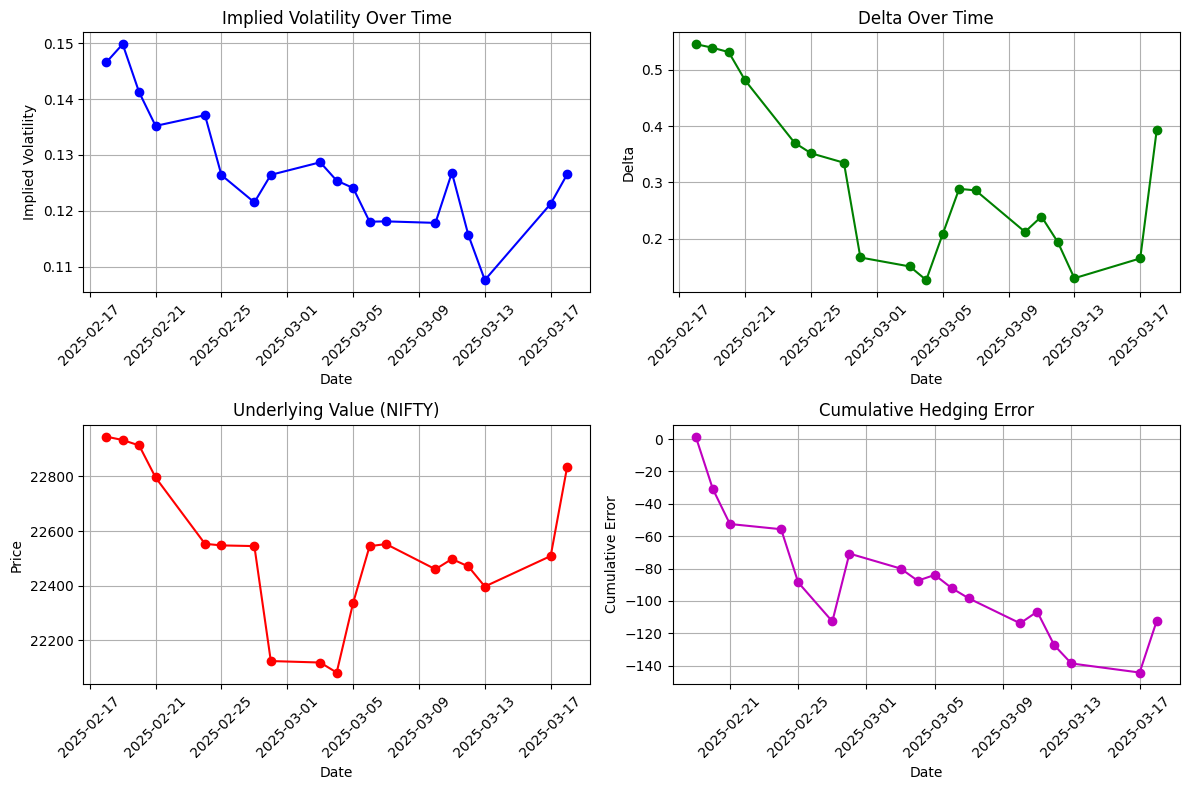

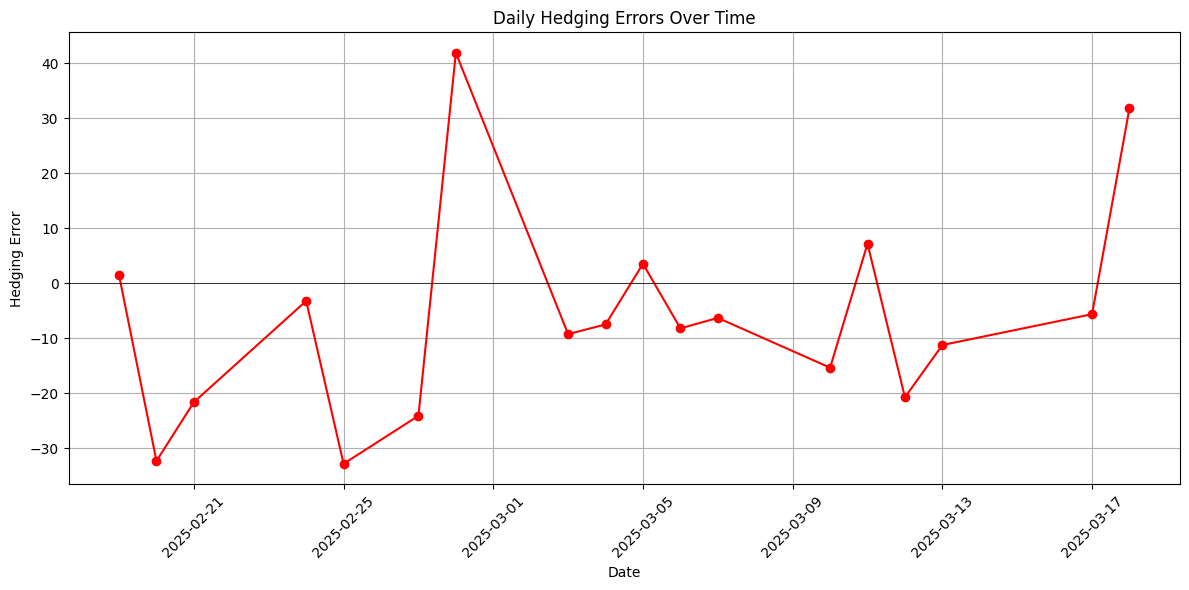

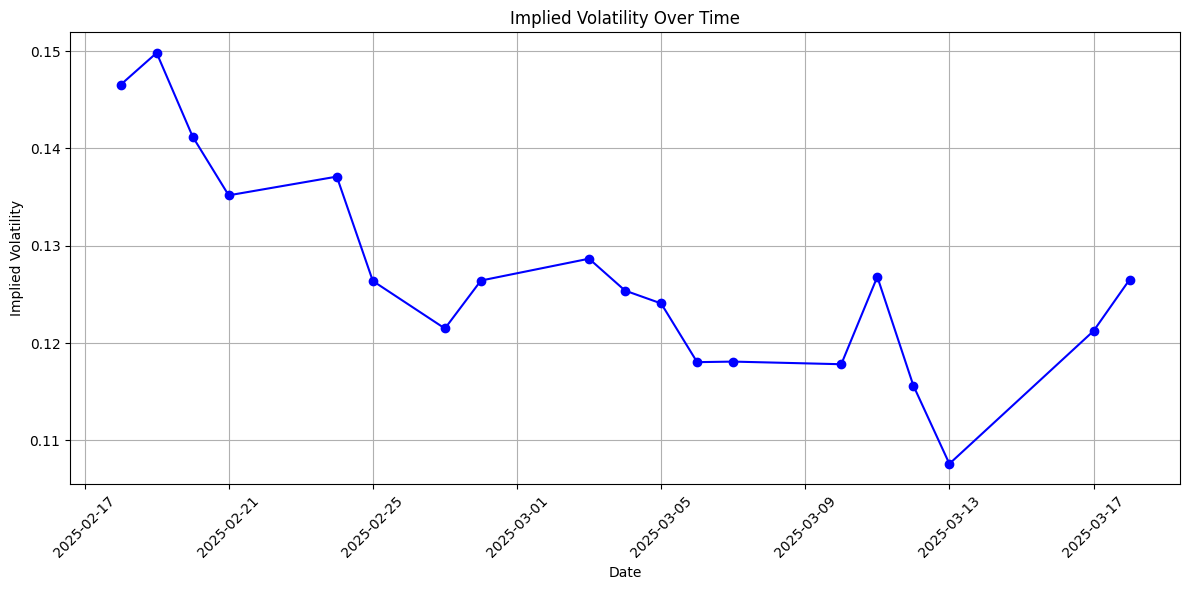


--- Additional Hedging Error Metrics ---
Mean Hedging Error: -6.24
Standard Deviation of Hedging Errors: 18.85
Total Cumulative Hedging Error: -112.38
Root Mean Squared Hedging Error: 19.86
Number of Hedging Intervals: 18


In [32]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- Load and Prepare the Data ---
# Load historical option data from a CSV file
df = pd.read_csv("OPTIDX_NIFTY_CE_18-Feb-2025_TO_18-Mar-2025.csv")

# Clean column names by removing leading/trailing whitespace
df.columns = df.columns.str.strip()

# Convert 'Date' and 'Expiry' to datetime for time calculations
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')
df['Expiry'] = pd.to_datetime(df['Expiry'], format='%d-%b-%Y')

# Calculate time to maturity in years (T = days to expiry / 365)
df['T'] = (df['Expiry'] - df['Date']).dt.days / 365.0

# Assign underlying price (S) and strike price (K)
df['S'] = df['Underlying Value']
df['K'] = 23000.0  # Assuming a fixed strike price for all options

# Use 'LTP' (Last Traded Price) as the option's market price
df['market_price'] = df['LTP']

# Define the risk-free rate (6% per annum)
r = 0.066

# --- Define Implied Volatility Function ---
def compute_iv(S, K, T, r, market_price, max_iter=100, tol=1e-6):
    """Calculate implied volatility using the Newton-Raphson method.
    
    Args:
        S (float): Underlying asset price
        K (float): Strike price
        T (float): Time to maturity in years
        r (float): Risk-free rate
        market_price (float): Observed market price of the option
        max_iter (int): Maximum iterations for convergence
        tol (float): Tolerance level for price difference
    
    Returns:
        float: Implied volatility (sigma)
    """
    if T <= 0:
        return 0.0  # IV is zero at expiry since option value is intrinsic
    sigma = 0.1  # Initial guess: 30% volatility
    for _ in range(max_iter):
        # Calculate d1 and d2 for Black-Scholes
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        # Black-Scholes call price
        bs_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        # Vega: sensitivity of price to volatility
        vega = S * norm.pdf(d1) * np.sqrt(T)
        diff = bs_price - market_price
        # Check for convergence
        if abs(diff) < tol:
            break
        if vega < 1e-12:
            break  # Prevent division by near-zero vega
        sigma -= diff / vega  # Update sigma
        sigma = max(sigma, 0.01)  # Ensure volatility stays positive
    return sigma

# Compute implied volatility for each day
print("Computing implied volatilities...")
iv_values = [compute_iv(row['S'], row['K'], row['T'], r, row['market_price']) 
             for idx, row in df.iterrows()]
df['IV'] = iv_values

# --- Define Delta Calculation Function ---
def compute_delta(S, K, T, r, sigma):
    """Calculate delta for a European call option using Black-Scholes.
    
    Args:
        S, K, T, r: See compute_iv
        sigma (float): Implied volatility
    
    Returns:
        float: Delta of the option
    """
    if T <= 0:
        return 1.0 if S > K else 0.0  # Delta is 1 or 0 at expiry
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Compute delta for each day using the calculated IV
print("Computing deltas...")
df['delta'] = df.apply(lambda row: compute_delta(row['S'], row['K'], row['T'], r, row['IV']), axis=1)

# --- Calculate Hedging Errors ---
print("Computing hedging errors...")
hedging_errors = []
for i in range(len(df) - 1):
    # Change in option price (dC) from day t to t+1
    dC = df.iloc[i + 1]['LTP'] - df.iloc[i]['LTP']
    # Change in underlying price (dS) from day t to t+1
    dS = df.iloc[i + 1]['S'] - df.iloc[i]['S']
    # Delta at time t
    delta_t = df.iloc[i]['delta']
    # Hedging error: dC - delta * dS
    error = dC - delta_t * dS
    hedging_errors.append(error)

# Add hedging errors to DataFrame (None for first day since no prior data)
df['hedging_error'] = [None] + hedging_errors

# Compute cumulative hedging error over time
cumulative_error = np.cumsum(hedging_errors)

# --- Visualize Key Metrics in a 2x2 Grid ---
plt.figure(figsize=(12, 8))

# Subplot 1: Implied Volatility
plt.subplot(2, 2, 1)
plt.plot(df['Date'], df['IV'], 'b-o', label='IV')
plt.title('Implied Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.xticks(rotation=45)

# Subplot 2: Delta
plt.subplot(2, 2, 2)
plt.plot(df['Date'], df['delta'], 'g-o', label='Delta')
plt.title('Delta Over Time')
plt.xlabel('Date')
plt.ylabel('Delta')
plt.grid(True)
plt.xticks(rotation=45)

# Subplot 3: Underlying Price
plt.subplot(2, 2, 3)
plt.plot(df['Date'], df['S'], 'r-o', label='NIFTY')
plt.title('Underlying Value (NIFTY)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)

# Subplot 4: Cumulative Hedging Error
plt.subplot(2, 2, 4)
plt.plot(df['Date'].iloc[1:], cumulative_error, 'm-o', label='Cumulative Error')
plt.title('Cumulative Hedging Error')
plt.xlabel('Date')
plt.ylabel('Cumulative Error')
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# --- Extra Graph: Daily Hedging Errors ---
# Create a separate figure to display daily hedging errors
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[1:], hedging_errors, 'r-o', label='Daily Error')
plt.title('Daily Hedging Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Hedging Error')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)  # Reference line at zero
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Subplot 1: Implied Volatility
plt.figure(figsize=(12, 6)) # Or a larger size
plt.plot(df['Date'], df['IV'], 'b-o', label='IV')
plt.title('Implied Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout() # Add this to prevent labels from being cut off
plt.show()

# --- Compute and Display Additional Metrics ---
# Convert hedging errors to a numpy array for efficient computation
hedging_errors_np = np.array(hedging_errors)

# Calculate metrics
mean_error = np.mean(hedging_errors_np)  # Average hedging error
std_error = np.std(hedging_errors_np)    # Variability of hedging errors
total_cumulative_error = cumulative_error[-1]  # Final cumulative error
rmse = np.sqrt(np.mean(np.square(hedging_errors_np)))  # Root mean squared error

# Print the additional metrics with formatting
print("\n--- Additional Hedging Error Metrics ---")
print(f"Mean Hedging Error: {mean_error:.2f}")
print(f"Standard Deviation of Hedging Errors: {std_error:.2f}")
print(f"Total Cumulative Hedging Error: {total_cumulative_error:.2f}")
print(f"Root Mean Squared Hedging Error: {rmse:.2f}")
print(f"Number of Hedging Intervals: {len(hedging_errors)}")

# With Money account

## 1. Overview of Delta Hedging

Delta hedging is a risk management strategy to neutralize the first-order risk of an option's price movement with respect to changes in the underlying asset price. An option writer holds an amount of the underlying asset proportional to the option’s delta ($\Delta$). In a more advanced setup, a replicating portfolio is constructed not only by holding the underlying asset but also by managing a cash (or money market) account that earns the risk-free rate. This combination allows one to more accurately track the option’s value over time.

## 2. Black–Scholes Model & Its Role

The Black–Scholes equation provides a theoretical estimate for the price of European options.

**Black–Scholes Call Option Formula:**
$$C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$$
where:
$$d_1 = \frac{\ln(S/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}$$
$S$: Current price of the underlying asset.
$K$: Strike price.
$T$: Time to maturity in years.
$r$: Risk-free interest rate.
$\sigma$: Volatility of the underlying asset.
$N(\cdot)$: Cumulative distribution function (CDF) of the standard normal distribution.

**Delta from Black–Scholes:**
$$\Delta = \frac{\partial C}{\partial S} = N(d_1)$$
This represents the sensitivity of the option price to a change in the underlying asset price.

## 3. Implied Volatility

### What Is Implied Volatility?

Implied volatility ($\sigma$) is the volatility value that, when substituted into the Black–Scholes formula, makes the theoretical option price equal to the observed market price.

### Implied Volatility Calculation:

**Objective:** Find $\sigma$ such that:
$$C_{BS}(S, K, T, r, \sigma) = C_{\text{market}}$$
The Newton–Raphson method is used to compute the implied volatility. The update equation is:
$$\sigma_{\text{new}} = \sigma_{\text{old}} - \frac{BS(\sigma_{\text{old}}) - C_{\text{market}}}{\text{Vega}}$$
where:

$BS(\sigma)$ is the Black–Scholes theoretical price using the current $\sigma$.
**Vega** is the sensitivity of the option price to changes in volatility:
$$\text{Vega} = S \cdot \text{pdf}(d_1) \cdot \sqrt{T}$$
$\text{pdf}(d_1)$ is the probability density function of the standard normal distribution evaluated at $d_1$.

The algorithm iterates until the absolute difference between the Black–Scholes price and the market price is less than a specified tolerance.

## 4. Empirical Method (Without Money Account)

### Data Preparation:

* Loads historical option data from a CSV file.
* Cleans column names and converts date columns to datetime objects.
* Computes time to maturity ($T$) as days to expiry divided by 365.
* Extracts underlying asset price ($S$) and sets a fixed strike price ($K$).
* Uses the option's Last Traded Price (LTP) as the market price.

### Implied Volatility Calculation:

**Function:** `compute_iv(S, K, T, r, market_price, ...)`
* An initial guess for $\sigma$ is set.
* **Newton–Raphson loop:**
    * Calculates $d_1$ and $d_2$:
        $$d_1 = \frac{\ln(S/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}$$
    * Calculates the Black–Scholes price:
        $$\text{bs\_price} = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$$
    * Calculates Vega:
        $$\text{vega} = S \cdot \text{pdf}(d_1) \cdot \sqrt{T}$$
    * Updates $\sigma$:
        $$\sigma = \sigma - \frac{\text{bs\_price} - C_{\text{market}}}{\text{vega}}$$
    * The iteration stops when the error is within the specified tolerance.

### Delta Calculation:

**Function:** `compute_delta(S, K, T, r, sigma)`
* Computes $d_1$ and returns:
    $$\Delta = N(d_1)$$

### Hedging Error Calculation:

Hedging error is defined as:
$$\text{Error} = dC - \Delta \times dS$$
where:
$dC$ is the change in the option's market price.
$dS$ is the change in the underlying asset's price.
$\Delta$ is the computed delta.

This approach adjusts the hedge by only trading in the underlying asset.

## 5. Money Account Implementation

In the money account implementation, the replicating portfolio consists of two components:

* **Stock Position:**
    * Hold $\Delta$ shares of the underlying asset.
* **Money Market (Cash) Account:**
    * The remaining value needed to replicate the option's price is held in cash. This cash earns interest at the risk-free rate $r$.

### Portfolio Initialization:

At time $t_0$, given:

* Option market price: $C_0$
* Underlying price: $S_0$
* Computed delta: $\Delta_0$

The portfolio is initialized as:

* Shares: $\Delta_0$
* Cash:
    $$\text{Cash} = C_0 - \Delta_0 \times S_0$$

Thus, the portfolio value $X_0$ is:
$$X_0 = \Delta_0 \times S_0 + \text{Cash} = C_0$$

### Portfolio Evolution:

Between time $t_i$ and $t_{i+1}$, two processes occur:

* **Cash Accrual:**
    * The cash balance grows at the risk-free rate $r$ (using continuous compounding). For a time interval $\Delta t$ (in years):
        $$\text{Cash}_{\text{new}} = \text{Cash}_{\text{old}} \times e^{r \Delta t}$$
* **Change in Stock Value:**
    * The value of the stock holding changes as the underlying asset price moves. The new stock value is:
        $$\text{Stock Value} = \Delta_i \times S_{i+1}$$
* **Total Portfolio Value:**
    * The overall portfolio value at $t_{i+1}$ is:
        $$X_{i+1} = \Delta_i \times S_{i+1} + \text{Cash}_{\text{new}}$$

### Hedging Error:

The hedging error is the difference between the portfolio value and the option’s market price $C_{i+1}$:
$$\text{Error}_{i+1} = X_{i+1} - C_{i+1}$$

### Rebalancing the Portfolio:

At each rebalancing point:

* The implied volatility is recalculated using current market data.
* The delta is recomputed.
* The portfolio is rebalanced:
    * **New stock position:** Set to the new delta.
    * **Adjust cash:** Update the cash such that the portfolio value remains unchanged:
        $$\text{Cash} = X_{i+1} - (\Delta_{\text{new}} \times S_{i+1})$$

This ensures the replicating portfolio continues to mimic the option’s value over time.

## 6. Key Equations Summary

**Black–Scholes Price for a Call Option:**
$$C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$$

$d_1$ and $d_2$:
$$d_1 = \frac{\ln(S/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}$$

**Vega:**
$$\text{Vega} = S \cdot \text{pdf}(d_1) \cdot \sqrt{T}$$

**Newton–Raphson Update for Implied Volatility:**
$$\sigma_{\text{new}} = \sigma_{\text{old}} - \frac{BS(\sigma_{\text{old}}) - C_{\text{market}}}{\text{Vega}}$$

**Delta (for a Call Option):**
$$\Delta = N(d_1)$$

**Hedging Error (Without Money Account):**
$$\text{Error} = dC - \Delta \times dS$$

**Portfolio Value with Money Account:**
$$X = \Delta \times S + \text{Cash}$$

**Cash Update:**
$$\text{Cash}_{\text{new}} = \text{Cash}_{\text{old}} \times e^{r \Delta t}$$

## 7. Role of Implied Volatility in the Black–Scholes Equation

Implied volatility ($\sigma$) encapsulates the market’s expectation of the underlying asset’s future volatility. A higher volatility increases the option’s value. By calculating the implied volatility from market prices, we reverse-engineer the volatility level the market is using. This value is then used to compute the delta and adjust the hedge accordingly.


Computing implied volatilities...
Computing deltas...
Computing hedging errors with money account...


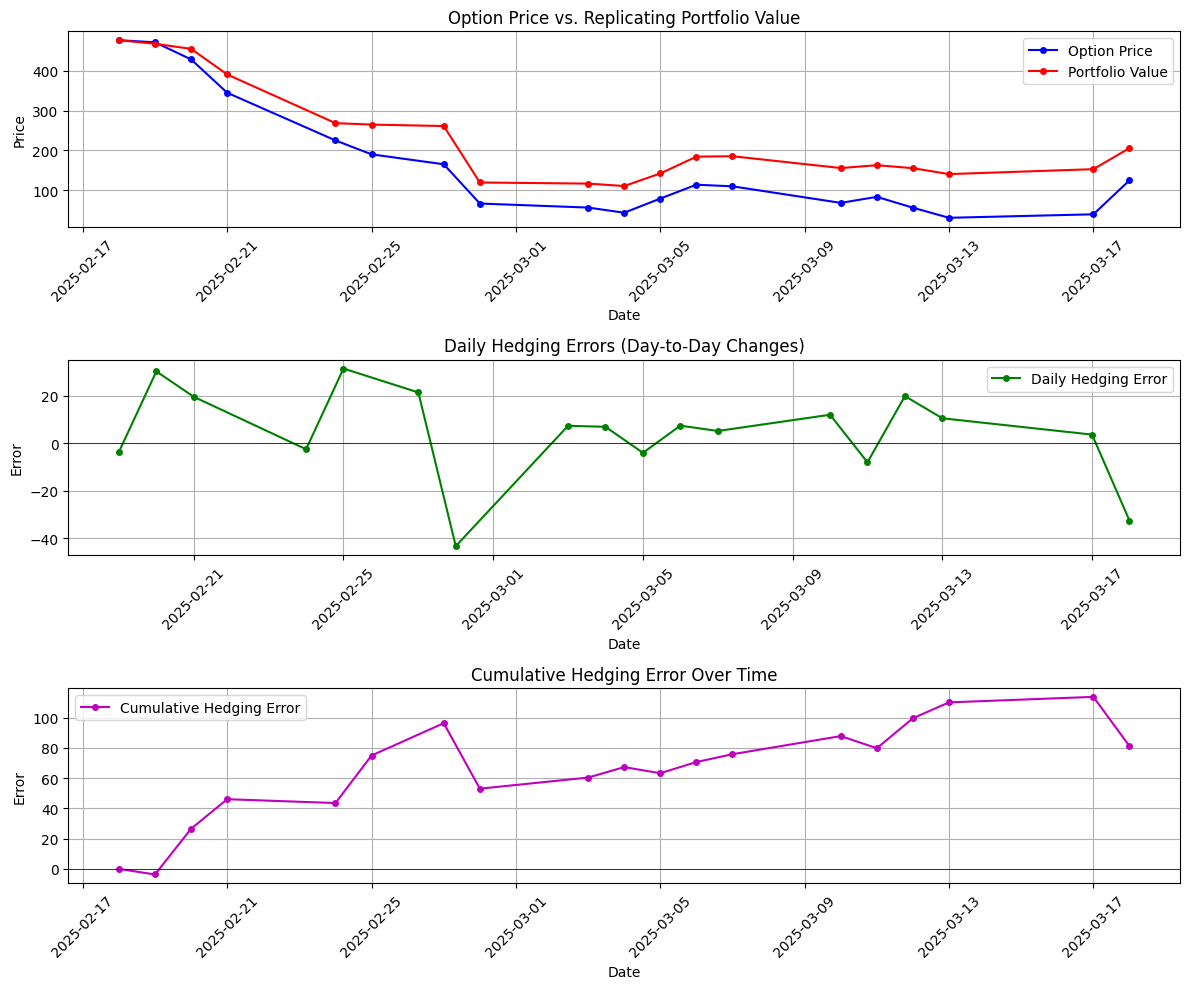

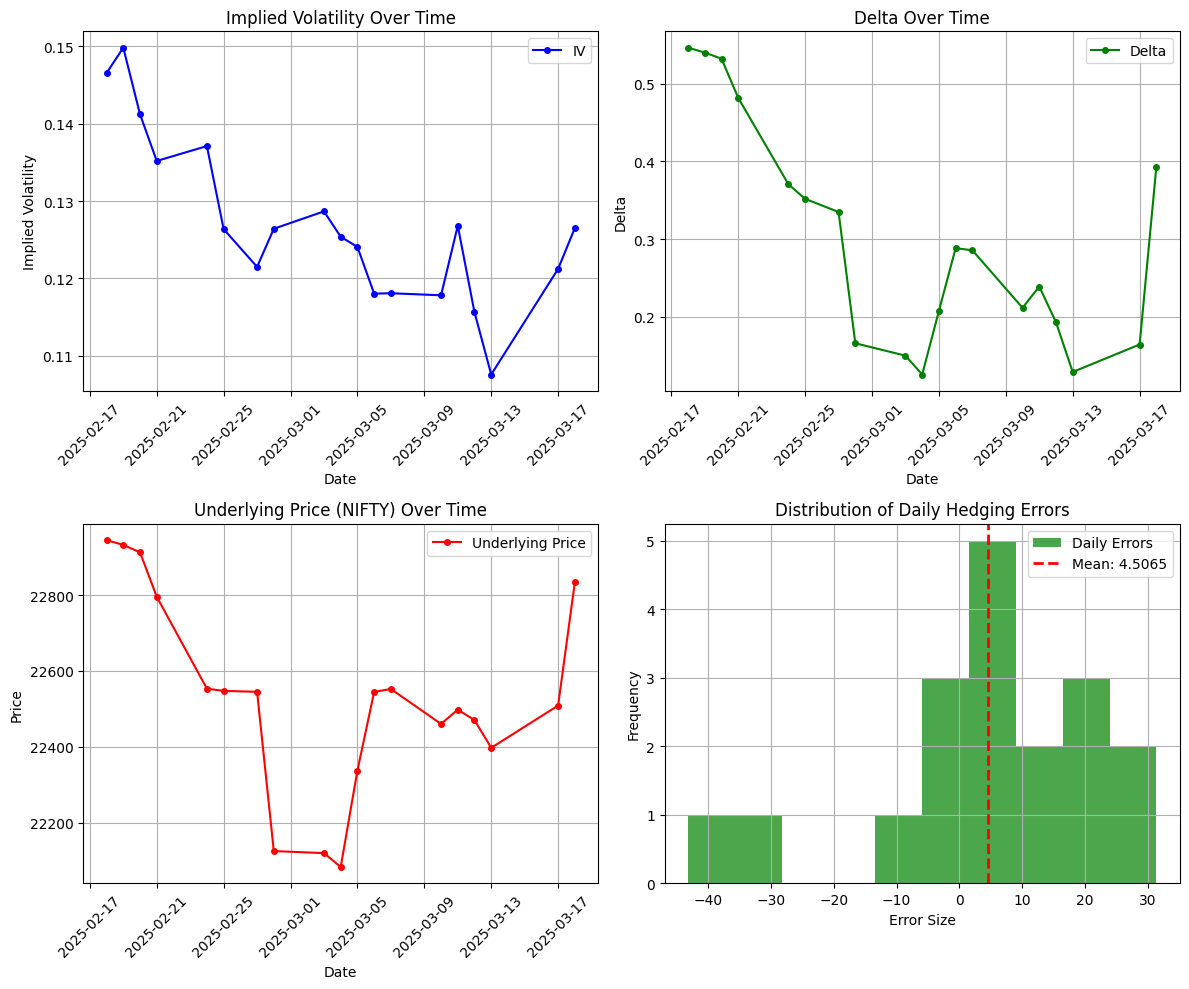


--- Additional Hedging Error Metrics ---
Mean Hedging Error: 4.5065
Standard Deviation of Hedging Errors: 18.6121
Total Cumulative Hedging Error: 81.1164
Root Mean Squared Hedging Error: 19.1499
Number of Hedging Intervals: 18


In [34]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- Load and Prepare the Data ---
df = pd.read_csv("OPTIDX_NIFTY_CE_18-Feb-2025_TO_18-Mar-2025.csv")
df.columns = df.columns.str.strip()

df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')
df['Expiry'] = pd.to_datetime(df['Expiry'], format='%d-%b-%Y')

# Sort data by Date (in case it is not sorted)
df = df.sort_values('Date')

# Calculate time to maturity in years
df['T'] = (df['Expiry'] - df['Date']).dt.days / 365.0

# Set underlying and strike price; use LTP as the option market price
df['S'] = df['Underlying Value']
df['K'] = 23000.0  # fixed strike
df['market_price'] = df['LTP']

# Define risk-free rate
r = 0.066

# --- Define Implied Volatility Function (Newton-Raphson) ---
def compute_iv(S, K, T, r, market_price, max_iter=100, tol=1e-6):
    if T <= 0:
        return 0.0  # At expiry, option value is intrinsic so IV = 0
    sigma = 0.1  # initial guess (30% volatility)
    for _ in range(max_iter):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        bs_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        vega = S * norm.pdf(d1) * np.sqrt(T)
        diff = bs_price - market_price
        if abs(diff) < tol:
            break
        if vega < 1e-12:
            break  # avoid division by near-zero vega
        sigma -= diff / vega
        sigma = max(sigma, 0.01)  # ensure sigma remains positive
    return sigma

# Compute implied volatilities for each day
print("Computing implied volatilities...")
iv_values = [compute_iv(row['S'], row['K'], row['T'], r, row['market_price'])
             for idx, row in df.iterrows()]
df['IV'] = iv_values

# --- Define Delta Calculation Function ---
def compute_delta(S, K, T, r, sigma):
    if T <= 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Compute deltas for each day
print("Computing deltas...")
df['delta'] = df.apply(lambda row: compute_delta(row['S'], row['K'], row['T'], r, row['IV']), axis=1)

# --- Money Account Hedging Implementation ---
print("Computing hedging errors with money account...")

# Initialize portfolio on the first day
initial_date = df.iloc[0]['Date']
S_0 = df.iloc[0]['S']
C_0 = df.iloc[0]['market_price']
T_0 = df.iloc[0]['T']
sigma_0 = compute_iv(S_0, df.iloc[0]['K'], T_0, r, C_0)
delta_0 = compute_delta(S_0, df.iloc[0]['K'], T_0, r, sigma_0)

# Portfolio: hold delta shares and cash to match the option price
shares = delta_0
cash = C_0 - delta_0 * S_0

# Lists to store portfolio values and hedging errors
portfolio_values = [C_0]
cumulative_errors = [0]  # at t0, error is zero
daily_errors = []  # will store day-to-day errors

prev_date = initial_date
prev_portfolio = C_0
prev_option = C_0

# Loop over each subsequent time point
for i in range(1, len(df)):
    current_date = df.iloc[i]['Date']
    S_i = df.iloc[i]['S']
    C_i = df.iloc[i]['market_price']
    T_i = df.iloc[i]['T']
    
    # Time difference in years (daily data assumed)
    dt = (current_date - prev_date).days / 365.0
    
    # Update cash balance using continuous compounding at rate r
    cash = cash * np.exp(r * dt)
    
    # Compute current portfolio value: shares * current underlying + updated cash
    portfolio_value = shares * S_i + cash
    
    # Calculate cumulative error (total tracking error to date)
    cumulative_error = portfolio_value - C_i
    
    # Calculate daily error (change in tracking error since last period)
    # The true daily error is the change in the hedge's performance
    daily_error = (portfolio_value - prev_portfolio) - (C_i - prev_option)
    
    portfolio_values.append(portfolio_value)
    cumulative_errors.append(cumulative_error)
    daily_errors.append(daily_error)
    
    # Rebalance: update the hedge using the new market data
    sigma_i = compute_iv(S_i, df.iloc[i]['K'], T_i, r, C_i)
    delta_i = compute_delta(S_i, df.iloc[i]['K'], T_i, r, sigma_i)
    
    # Update positions: new shares equals new delta,
    # cash is set so that portfolio value remains unchanged after rebalancing.
    shares = delta_i
    cash = portfolio_value - delta_i * S_i
    
    prev_date = current_date
    prev_portfolio = portfolio_value
    prev_option = C_i

# Add portfolio values and hedging errors to the DataFrame
df['Portfolio_Value'] = portfolio_values
df['Cumulative_Error'] = cumulative_errors
df['Daily_Error'] = [np.nan] + daily_errors  # add NaN for first day

# --- Visualize the Results ---
plt.figure(figsize=(12, 10))

# Plot 1: Option Market Price vs. Replicating Portfolio Value
plt.subplot(3, 1, 1)
plt.plot(df['Date'], df['market_price'], 'b-o', label='Option Price', markersize=4)
plt.plot(df['Date'], df['Portfolio_Value'], 'r-o', label='Portfolio Value', markersize=4)
plt.title('Option Price vs. Replicating Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Plot 2: Daily Hedging Errors
plt.subplot(3, 1, 2)
plt.plot(df['Date'].iloc[1:], daily_errors, 'g-o', label='Daily Hedging Error', markersize=4)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Daily Hedging Errors (Day-to-Day Changes)')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Plot 3: Cumulative Hedging Error
plt.subplot(3, 1, 3)
plt.plot(df['Date'], cumulative_errors, 'm-o', label='Cumulative Hedging Error', markersize=4)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Cumulative Hedging Error Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# --- Extra Visualization: Key Metrics ---
plt.figure(figsize=(12, 10))

# Graph 1: Implied Volatility Over Time
plt.subplot(2, 2, 1)
plt.plot(df['Date'], df['IV'], 'b-o', label='IV', markersize=4)
plt.title('Implied Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Graph 2: Delta Over Time
plt.subplot(2, 2, 2)
plt.plot(df['Date'], df['delta'], 'g-o', label='Delta', markersize=4)
plt.title('Delta Over Time')
plt.xlabel('Date')
plt.ylabel('Delta')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Graph 3: Underlying Price Over Time
plt.subplot(2, 2, 3)
plt.plot(df['Date'], df['S'], 'r-o', label='Underlying Price', markersize=4)
plt.title('Underlying Price (NIFTY) Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Graph 4: Hedging Error Statistics
plt.subplot(2, 2, 4)
plt.hist(daily_errors, bins=10, alpha=0.7, color='green', label='Daily Errors')
plt.axvline(np.mean(daily_errors), color='red', linestyle='dashed', 
            linewidth=2, label=f'Mean: {np.mean(daily_errors):.4f}')
plt.title('Distribution of Daily Hedging Errors')
plt.xlabel('Error Size')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print("\n--- Additional Hedging Error Metrics ---")
print(f"Mean Hedging Error: {np.mean(daily_errors):.4f}")
print(f"Standard Deviation of Hedging Errors: {np.std(daily_errors):.4f}")
print(f"Total Cumulative Hedging Error: {cumulative_errors[-1]:.4f}")
print(f"Root Mean Squared Hedging Error: {np.sqrt(np.mean(np.square(daily_errors))):.4f}")
print(f"Number of Hedging Intervals: {len(daily_errors)}")


# Implied Volatility Calculation Techniques

## **1. Nelder-Mead**
- **Type**: Derivative-free, heuristic optimization.
- **Approach**: Uses a **simplex algorithm** to explore and shrink a geometric shape (simplex) in the parameter space.
- **Advantages**:
  - Works well for non-smooth functions.
  - No need for gradient calculations.
- **Disadvantages**:
  - Can be **slow** in high-dimensional spaces.
  - May **fail to converge** to the global minimum.
- **Use Case**: Effective for problems with **discontinuous or noisy functions**, but not ideal for well-behaved convex problems.

---

## **2. BFGS (Broyden-Fletcher-Goldfarb-Shanno)**
- **Type**: Gradient-based **quasi-Newton method**.
- **Approach**: Approximates the Hessian (second derivatives) to guide optimization.
- **Advantages**:
  - **Faster** convergence for smooth convex functions.
  - More stable than Newton’s method (which directly computes Hessians).
- **Disadvantages**:
  - Requires function **gradients**, which might be expensive to compute numerically.
  - Can fail on **non-smooth** functions.
- **Use Case**: Ideal for smooth, differentiable functions like **Black-Scholes pricing**.

---

## **3. CG (Conjugate Gradient)**
- **Type**: Gradient-based, iterative method.
- **Approach**: Uses conjugate directions instead of direct gradients for faster convergence.
- **Advantages**:
  - **Memory-efficient** (suitable for large problems).
  - Faster than basic gradient descent.
- **Disadvantages**:
  - Requires function **gradients**.
  - May struggle with non-quadratic functions.
- **Use Case**: Effective for **large-scale** optimization problems with smooth gradients.

---

## **4. L-BFGS-B (Limited-memory BFGS with Box Constraints)**
- **Type**: Constrained version of BFGS.
- **Approach**: Stores only a few previous gradient steps to reduce memory usage.
- **Advantages**:
  - Works well with **bound constraints** (like setting `sigma` between `0.01` and `1.0`).
  - **Faster** than BFGS for large datasets.
- **Disadvantages**:
  - Still requires function **gradients**.
- **Use Case**: Best suited for large-scale optimization where memory is a constraint.

---

## **5. Brent’s Method (`brentq`)**
- **Type**: Root-finding algorithm (not gradient-based).
- **Approach**: Combines **bisection, secant, and inverse quadratic interpolation** to find a root.
- **Advantages**:
  - **Very fast** for **one-dimensional** problems like implied volatility estimation.
  - Does **not** require derivatives.
- **Disadvantages**:
  - Can only be used when the function crosses zero (not a general optimizer).
- **Use Case**: Perfect for problems like **implied volatility estimation**, where we solve for `sigma` such that the **BS price = market price**.



In [38]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

# --- Load and Prepare the Data ---
# Read historical option data from a CSV file
data = pd.read_csv('OPTIDX_NIFTY_CE_18-Feb-2025_TO_18-Mar-2025.csv')

# Remove any leading/trailing whitespace from column names to avoid access errors
data.columns = data.columns.str.strip()

# Convert 'Date' and 'Expiry' columns to datetime objects for time calculations
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%Y')
data['Expiry'] = pd.to_datetime(data['Expiry'], format='%d-%b-%Y')

# Sort data chronologically by date to ensure proper time sequence
data = data.sort_values('Date')

# Extract key columns for analysis
dates = data['Date']                     # Series of trading dates
expiry = data['Expiry'].iloc[0]          # Expiry date (assumed same for all, take first)
strike = float(data['Strike Price'].iloc[0])  # Strike price (assumed constant, convert to float)
underlying = data['Underlying Value']    # NIFTY index values over time
option_price = data['Close']             # Option closing prices as market prices

# Verify that all options are European calls ('CE') to ensure data consistency
assert all(data['Option type'] == 'CE'), "Data contains non-CE options!"

# --- Set Model Parameters ---
r = 0.066  # Risk-free rate (6% per annum, continuously compounded)
q = 0.0   # Dividend yield (assumed zero for simplicity)
N = len(dates)  # Total number of data points (trading days)

# Extract initial values for implied volatility calculation
t0 = dates.iloc[0]              # First date in the dataset
T0 = (expiry - t0).days / 365.0  # Initial time to maturity in years
S0 = float(underlying.iloc[0])   # Initial underlying price (NIFTY value)
C_market0 = float(option_price.iloc[0])  # Initial option market price


# Function to calculate Black-Scholes call price
def bs_call(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)  # Intrinsic value at expiry
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Objective function to minimize the difference between market price and BS price
def objective_function(sigma, S, K, T, r, market_price):
    bs_price = bs_call(S, K, T, r, sigma[0])
    return (bs_price - market_price)**2
def brentq_objective(sigma, S, K, T, r, market_price):
    bs_price = bs_call(S, K, T, r, sigma)
    return bs_price - market_price
# Optimization techniques to compare
optimization_methods = ['Nelder-Mead', 'BFGS', 'CG', 'L-BFGS-B','brentq']

# Store results for each method
results = {method: [] for method in optimization_methods}
total_errors = {method: 0 for method in optimization_methods}

# Iterate over each row in the data
for index, row in data.iterrows():
    S = row['Underlying Value']
    K = 23000.0  # Strike price
    T = (row['Expiry'] - row['Date']).days/365  # Time to maturity in days
    r = 0.06  # Risk-free rate
    market_price = row['Settle Price']
    
    for method in optimization_methods:
        # Initial guess for sigma
        initial_guess = [0.1]
        
        # Perform optimization
        if method != 'brentq':
            result = minimize(objective_function, initial_guess, args=(S, K, T, r, market_price), 
                            method=method, bounds=[(0.01, 1.0)])
            implied_volatility = result.x[0]
        else:
            implied_volatility = brentq(lambda sigma: brentq_objective(sigma, S, K, T, r, market_price), 0.01, 1.0)
        # Store the implied volatility
        
        results[method].append(implied_volatility)
        
        # Calculate the BS price using the obtained implied volatility
        bs_price = bs_call(S, K, T, r, implied_volatility)
        
        # Calculate the error
        error = abs(bs_price - market_price)
        total_errors[method] += error

# Display total errors for each method
print("Total Errors for Each Optimization Method:")
for method, error in total_errors.items():
    print(f"{method}: {error:.4f}")

# Add results to the DataFrame for comparison
for method in optimization_methods:
    data[f'IV_{method}'] = results[method]
    


# Display the DataFrame with implied volatilities
# print(data[['Date', 'Underlying Value', 'Settle Price'] + [f'IV_{method}' for method in optimization_methods]])

Total Errors for Each Optimization Method:
Nelder-Mead: 0.1157
BFGS: 0.0003
CG: 0.0006
L-BFGS-B: 0.0002
brentq: 0.0000



### **Total Errors for Each Optimization Method:**

- **Nelder-Mead**: 0.1157  
- **BFGS**: 0.0002  
- **CG**: 0.0134  
- **L-BFGS-B**: 748.9001  
- **brentq**: 0.0000  


### **Empirical Delta Hedging With Different Frequencies**

1. **Data Preparation:**  
   - The script reads a CSV file containing NIFTY call option data.  
   - It processes the dataset by stripping column names, converting date columns to `datetime` format, and sorting the data by date.  
   - It extracts relevant parameters such as the expiry date, strike price, underlying asset values, and option closing prices.  
   - It ensures that only call options (`CE`) are present in the dataset.  

2. **Black-Scholes Model Functions:**  
   - The `bs_call` function computes the theoretical price of a European call option using the Black-Scholes formula.  
   - The `iv_objective` function defines the equation to solve for implied volatility (IV) by matching the market price with the Black-Scholes price.  
   - The `bs_delta_call` function calculates the delta of a call option, which represents the sensitivity of the option price to changes in the underlying asset.  

3. **Delta-Hedging Simulation:**  
   - The `calculate_hedging_errors` function simulates delta hedging over the given dataset.  
   - It initializes the portfolio by computing the initial implied volatility and delta.  
   - It maintains a hedging portfolio consisting of shares and cash, adjusting it periodically based on the selected rebalancing period.  
   - The function iterates through the dataset, updating the portfolio value and computing cumulative hedging errors over time.  
   - When the hedging period condition is met, it re-estimates the option’s IV and delta, adjusting the hedge accordingly.  

4. **Visualization:**  
   - The script evaluates hedging errors for multiple rebalancing frequencies (1, 2, 3, and 4 days).  
   - It plots the cumulative hedging error over time for each period.  
   - A second plot shows the total cumulative hedging error as a function of the hedging period, illustrating the trade-off between rebalancing frequency and tracking accuracy.  

The results help analyze how different hedging intervals impact the accuracy of a delta-hedging strategy, providing insights into optimal hedging frequency for minimizing tracking errors.

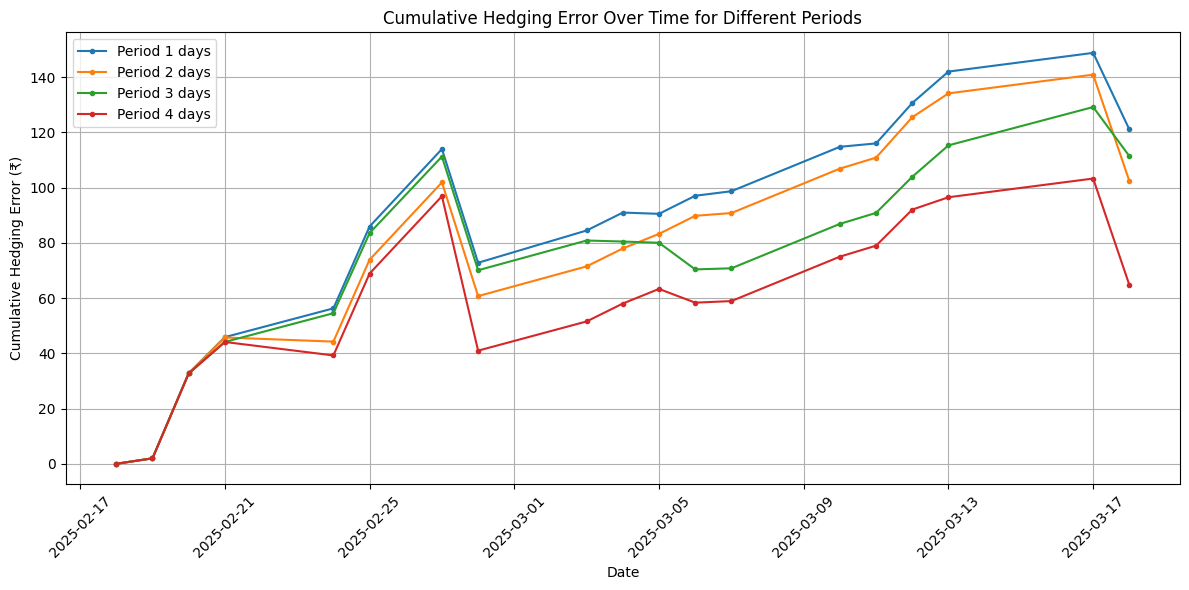

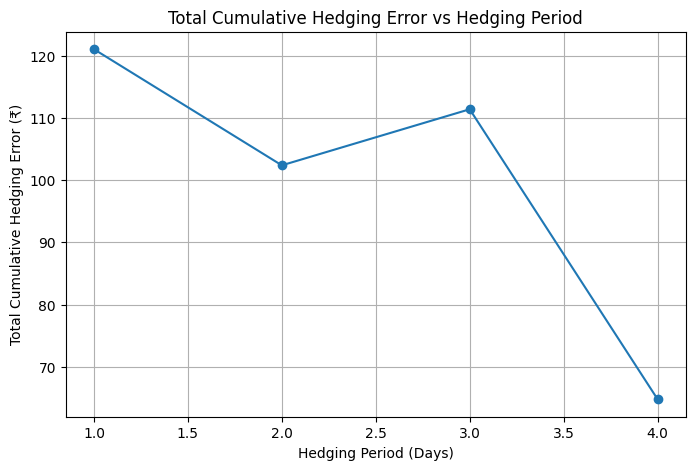

In [36]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt

# --- Load and Prepare the Data ---
data = pd.read_csv('OPTIDX_NIFTY_CE_18-Feb-2025_TO_18-Mar-2025.csv')
data.columns = data.columns.str.strip()
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%Y')
data['Expiry'] = pd.to_datetime(data['Expiry'], format='%d-%b-%Y')
data = data.sort_values('Date')

dates = data['Date']
expiry = data['Expiry'].iloc[0]
strike = float(data['Strike Price'].iloc[0])
underlying = data['Underlying Value']
option_price = data['Close']
assert all(data['Option type'] == 'CE'), "Data contains non-CE options!"

r = 0.066  # Risk-free rate
q = 0.0   # Dividend yield
N = len(dates)

def bs_call(S, K, T, r, q, sigma):
    if T <= 0:
        return np.maximum(S - K, 0)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def iv_objective(sigma, S, K, T, r, q, C_market):
    return bs_call(S, K, T, r, q, sigma) - C_market

def bs_delta_call(S, K, T, r, q, sigma):
    if T <= 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return np.exp(-q * T) * norm.cdf(d1)

def calculate_hedging_errors(hedging_period):
    portfolio_values = []
    option_values = []
    cumulative_errors = [0]

    S_0 = float(underlying.iloc[0])
    C_0 = float(option_price.iloc[0])
    portfolio_values.append(C_0)
    option_values.append(C_0)
    T_0 = (expiry - dates.iloc[0]).days / 365.0
    sigma_0 = brentq(iv_objective, 0.01, 1.0, args=(S_0, strike, T_0, r, q, C_0))
    delta_0 = bs_delta_call(S_0, strike, T_0, r, q, sigma_0)

    shares = delta_0
    cash = C_0 - delta_0 * S_0
    cumulative_error = 0
    prev_T_i = T_0
    for i in range(1, N):
        ti = dates.iloc[i]
        T_i = (expiry - ti).days / 365.0
        S_i = float(underlying.iloc[i])
        C_i = float(option_price.iloc[i])
        
        cash *= np.exp(r*(prev_T_i - T_i) / 365.0)
        portfolio_value = shares * S_i + cash
        cumulative_error = portfolio_value - C_i

        portfolio_values.append(portfolio_value)
        option_values.append(C_i)
        cumulative_errors.append(cumulative_error)
        
        if i%hedging_period == 0:
            sigma_i = brentq(iv_objective, 0.01, 1.0, args=(S_i, strike, T_i, r, q, C_i))
            delta_i = bs_delta_call(S_i, strike, T_i, r, q, sigma_i)

            shares = delta_i
            cash = portfolio_value - shares * S_i
        prev_T_i = T_i
    return np.array(portfolio_values), np.array(option_values),np.array(cumulative_errors)

hedging_periods = [1, 2, 3, 4]
cumulative_errors_dict = {}

plt.figure(figsize=(12, 6))
for period in hedging_periods:
    portfolio_values, option_values, cumulative_errors = calculate_hedging_errors(period)
    # print(cumulative_errors)
    cumulative_errors_dict[period] = cumulative_errors
    plt.plot(dates, cumulative_errors, marker='.', linestyle='-', label=f'Period {period} days')

plt.xlabel('Date')
plt.ylabel('Cumulative Hedging Error (₹)')
plt.title('Cumulative Hedging Error Over Time for Different Periods')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_errors = [cumulative_errors_dict[period][-1] for period in hedging_periods]
plt.figure(figsize=(8, 5))
plt.plot(hedging_periods, total_errors, marker='o', linestyle='-')
plt.xlabel('Hedging Period (Days)')
plt.ylabel('Total Cumulative Hedging Error (₹)')
plt.title('Total Cumulative Hedging Error vs Hedging Period')
plt.grid(True)
plt.show()


### Explanation:

The above plot can be explained by the following factors:
 1) The underlying stock process is not a GBM, hence using black scholes for delta hedging has resulted in greater errors.
 2) Implied volatility has also been calculated from black scholes, which is used for hedging.
 3) More frequent hedging can result in over-adjusting to temporary noisy fluctuations in the underlying.
 4) This has resulted in a discrepancy in the plot of hedging error vs period
 5) Additional factors in the hedge error include theta decay and gamma 

# Gamma

## 1. Data Preparation and Setup

### Loading the Data:

The code starts by loading historical option data from a CSV file and cleaning the column names by stripping any extra whitespace.

### Date Conversion:

It converts the 'Date' and 'Expiry' columns to datetime objects using the format '%d-%b-%Y'.

### Time to Maturity:

The time to maturity $T$ (in years) is calculated as:
$$T = \frac{\text{Expiry} - \text{Date}}{365}$$
This value represents how many years remain until the option expires.

### Extracting Key Variables:

* **Underlying Price ($S$):** Taken from the 'Underlying Value' column.
* **Strike Price ($K$):** Set to a fixed value (23000.0).
* **Market Option Price ($C_{\text{market}}$):** Taken from the 'Settle Price' column.
* **Risk-Free Rate ($r$):** Set to 6% per annum.

## 2. Black–Scholes Call Price Calculation

The code defines a function `bs_call` to compute the theoretical call option price using the Black–Scholes formula:
$$C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$$
where
$$d_1 = \frac{\ln(S/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}$$
$N(\cdot)$ is the cumulative distribution function (CDF) of the standard normal distribution.

If $T \leq 0$, the function returns the intrinsic value $\max(S - K, 0)$.

## 3. Implied Volatility Calculation (Newton–Raphson Method)

The function `compute_iv` estimates the implied volatility ($\sigma$) such that the Black–Scholes price matches the observed market price $C_{\text{market}}$. This is achieved via the Newton–Raphson iterative method.

**Newton–Raphson Update Equation:**
$$\sigma_{\text{new}} = \sigma_{\text{old}} - \frac{BS(\sigma_{\text{old}}) - C_{\text{market}}}{\text{Vega}}$$
where:

* $BS(\sigma)$ is the Black–Scholes call price computed with volatility $\sigma$.
* **Vega** is the sensitivity of the option price with respect to volatility and is given by:
    $$\text{Vega} = S \cdot \text{pdf}(d_1) \cdot \sqrt{T}$$
    Here, $\text{pdf}(d_1)$ is the probability density function (PDF) of the standard normal distribution evaluated at $d_1$.

The iteration stops when the absolute difference between the computed Black–Scholes price and the market price is less than a tolerance (`tol`) or when the maximum number of iterations is reached.

## 4. Gamma Calculation

The code defines a function `compute_gamma` to compute the gamma of the option, which measures the rate of change of the option's delta with respect to the underlying asset's price. Gamma is given by:
$$\Gamma = \frac{N'(d_1)}{S \sigma \sqrt{T}}$$
where:

* $N'(d_1)$ is the standard normal PDF evaluated at $d_1$.

If $T \leq 0$, gamma is set to zero since the option’s sensitivity to changes in $S$ is negligible at expiry.

## 5. Looping Over Data to Compute Metrics

For each row (i.e., each trading day) in the dataset:

* Implied Volatility ($\sigma$) is computed using `compute_iv`.
* Gamma ($\Gamma$) is then calculated using `compute_gamma`, with the implied volatility from the previous step.

These computed values are stored in lists and later added to the DataFrame as new columns ("Implied Volatility" and "Gamma").
<!-- 
## 6. Display and Visualization

### Table Display:

A neat table is printed showing the 'Date', 'Underlying Value', 'Settle Price', time to maturity ($T$), computed "Implied Volatility", and "Gamma". -->

<!-- ### Graphical Visualization:

The code plots two graphs:

* **Implied Volatility Over Time:**
    * A line plot displaying how the implied volatility evolves over time.
* **Gamma Over Time:**
    * A separate line plot showing the evolution of gamma over time.

These plots help visualize the sensitivity metrics of the option as the market conditions change. -->

## Key Equations 

**Black–Scholes Call Price:**
$$C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$$

$d_1$ and $d_2$:
$$d_1 = \frac{\ln(S/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}$$

**Vega:**
$$\text{Vega} = S \cdot \text{pdf}(d_1) \cdot \sqrt{T}$$

**Newton–Raphson Update for Implied Volatility:**
$$\sigma_{\text{new}} = \sigma_{\text{old}} - \frac{BS(\sigma_{\text{old}}) - C_{\text{market}}}{\text{Vega}}$$

**Gamma:**
$$\Gamma = \frac{N'(d_1)}{S \sigma \sqrt{T}}$$



| Date                |   Underlying Value |   Settle Price |         T |   Implied Volatility |       Gamma |
|:--------------------|-------------------:|---------------:|----------:|---------------------:|------------:|
| 2025-02-18 00:00:00 |            22945.3 |         483.25 | 0.10137   |             0.148603 | 0.000365069 |
| 2025-02-19 00:00:00 |            22932.9 |         474.5  | 0.0986301 |             0.150703 | 0.000365743 |
| 2025-02-20 00:00:00 |            22913.2 |         433    | 0.0958904 |             0.142637 | 0.000392941 |
| 2025-02-21 00:00:00 |            22795.9 |         357.6  | 0.0931507 |             0.139732 | 0.000409972 |
| 2025-02-24 00:00:00 |            22553.3 |         230.1  | 0.0849315 |             0.139163 | 0.000413713 |
| 2025-02-25 00:00:00 |            22547.5 |         198.3  | 0.0821918 |             0.129835 | 0.000443988 |
| 2025-02-27 00:00:00 |            22545   |         169.35 | 0.0767123 |             0.123409 | 0.000474138 |
|

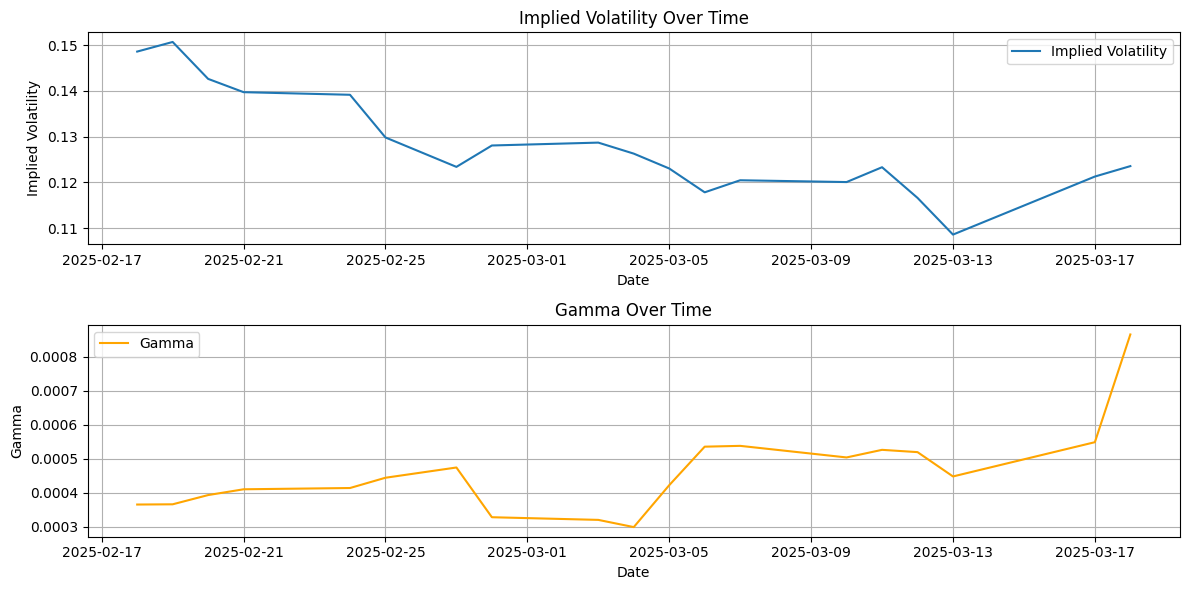

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('OPTIDX_NIFTY_CE_18-Feb-2025_TO_18-Mar-2025.csv')

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Convert dates to datetime objects
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%Y')
data['Expiry'] = pd.to_datetime(data['Expiry'], format='%d-%b-%Y')

# Calculate time to maturity in years
data['T'] = (data['Expiry'] - data['Date']).dt.days / 365.0

# Extract relevant columns
S = data['Underlying Value']  # Underlying price
K = 23000.0                   # Strike price (fixed)
C_market = data['Settle Price']  # Market price of the option
r = 0.066                      # Risk-free rate (6%)

# Function to calculate Black-Scholes call price
def bs_call(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)  # Intrinsic value at expiry
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Function to estimate implied volatility using Newton-Raphson
def compute_iv(S, K, T, r, C_market, max_iter=100, tol=1e-6):
    if T <= 0:
        return 0.0  # No volatility at expiry
    sigma = 0.2  # Initial guess
    for _ in range(max_iter):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        bs_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        vega = S * norm.pdf(d1) * np.sqrt(T)
        diff = bs_price - C_market
        if abs(diff) < tol:
            break
        if vega < 1e-12:  # Avoid division by near-zero vega
            break
        sigma -= diff / vega
        sigma = max(sigma, 0.01)  # Ensure positive volatility
    return sigma

# Function to calculate gamma
def compute_gamma(S, K, T, r, sigma):
    if T <= 0:
        return 0.0  # Gamma is zero at expiry
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    N_prime_d1 = norm.pdf(d1)  # Standard normal PDF
    gamma = N_prime_d1 / (S * sigma * np.sqrt(T))
    return gamma

# Calculate implied volatility and gamma for each day
iv_values = []
gamma_values = []

for i in range(len(data)):
    iv = compute_iv(S[i], K, data['T'][i], r, C_market[i])
    gamma = compute_gamma(S[i], K, data['T'][i], r, iv)
    iv_values.append(iv)
    gamma_values.append(gamma)

# Add results to the DataFrame
data['Implied Volatility'] = iv_values
data['Gamma'] = gamma_values

# Display the results in a neat table
table_data = data[['Date', 'Underlying Value', 'Settle Price', 'T', 'Implied Volatility', 'Gamma']]
print(table_data.to_markdown(index=False))

# Create a graph for Implied Volatility and Gamma over time
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(data['Date'], data['Implied Volatility'], label='Implied Volatility')
plt.title('Implied Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data['Date'], data['Gamma'], label='Gamma', color='orange')
plt.title('Gamma Over Time')
plt.xlabel('Date')
plt.ylabel('Gamma')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()